# KNN classification

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv("../dataset/satellite_signal_dataset.csv")
df.head()

,orbit_type,distance_m,frequency_hz,transmit_power_dbw,transmit_antenna_diameter_m,receive_antenna_diameter_m,rain_rate_mmhr,atmospheric_loss_db,pointing_error_deg,bandwidth_hz,...,transmit_antenna_gain_db,receive_antenna_gain_db,fspl_db,rain_attenuation_db,pointing_loss_db,transmit_power_dbm,received_power_dbm,noise_power_dbm,cn_ratio_db,signal_quality
0,GEO,3.565755e+07,1.626957e+09,24.599966,1.097824,2.302199,8.523263,1.951948,0.057916,2.376473e+07,...,23.220260,29.652463,187.712322,0.046653,0.001281,54.599966,-82.239514,-101.064908,18.825394,Good
1,MEO,1.153046e+07,2.732246e+10,13.690240,0.689636,2.678975,0.784847,1.817429,0.000000,2.574373e+07,...,43.684873,55.471854,202.409099,2.781469,0.000000,43.690240,-64.161030,-100.093471,35.932441,Good
2,LEO,8.547917e+05,6.435908e+09,16.932794,0.752718,1.550586,14.636986,1.377592,0.080622,4.398066e+07,...,31.886933,38.164197,167.251175,0.163628,0.017614,46.932794,-51.826086,-101.616579,49.790493,Good
3,LEO,6.793379e+05,2.754270e+10,23.265613,0.861342,1.080783,9.264690,1.733032,1.207310,2.521968e+06,...,45.685729,47.656980,177.883618,1.511315,35.145513,53.265613,-69.665155,-110.930365,41.265211,Good
4,GEO,3.586736e+07,1.499221e+10,19.641787,0.907307,1.160886,12.557483,1.412742,0.000000,2.388476e+07,...,40.854477,42.995185,207.053070,45.040371,0.000000,49.641787,-120.014733,-103.200321,-16.814412,Poor


In [25]:
# Encoding target
labels, uniques = pd.factorize(df['signal_quality'])
X = df.drop(columns=['signal_quality'])
y = labels

In [26]:
# One-hot for categorical orbit_type
X = pd.get_dummies(X, drop_first=True).values

In [27]:
# train-test data split
np.random.seed(42)
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8 * len(X))
train_idx, test_idx = idx[:split], idx[split:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [28]:
# KNN model
class KNN:
    def __init__(self, k=5):
        self.k = k
    def fit(self, X, y):
        self.X_train = X.astype(np.float64)
        self.y_train = y
    def predict_one(self, x):
        dist = np.linalg.norm(self.X_train - x, axis=1)
        k_idx = np.argsort(dist)[:self.k]
        k_labels = self.y_train[k_idx]
        vals, counts = np.unique(k_labels, return_counts=True)
        return vals[np.argmax(counts)]
    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

In [29]:
# applying KNN model
knn = KNN(k=5)
knn.fit(X_train, y_train)

In [30]:
# predict on test data
y_pred = knn.predict(X_test.reshape(-1, X_train.shape[1]).astype(np.float64))

In [31]:
# evaluation metrics
accuracy = np.mean(y_pred == y_test)

precision = []
recall = []
for c in np.unique(y_test):
    tp = np.sum((y_pred == c) & (y_test == c))
    fp = np.sum((y_pred == c) & (y_test != c))
    fn = np.sum((y_pred != c) & (y_test == c))
    precision.append(tp / (tp + fp + 1e-9))
    recall.append(tp / (tp + fn + 1e-9))

print("Accuracy:", accuracy)
print("Precision per class:", precision)
print("Recall per class:", recall)

Accuracy: 0.81225
Precision per class: [np.float64(0.8475693490796903), np.float64(0.4760479041901915), np.float64(0.1599999999936)]
Recall per class: [np.float64(0.9495384615381693), np.float64(0.2906764168184814), np.float64(0.01970443349743988)]


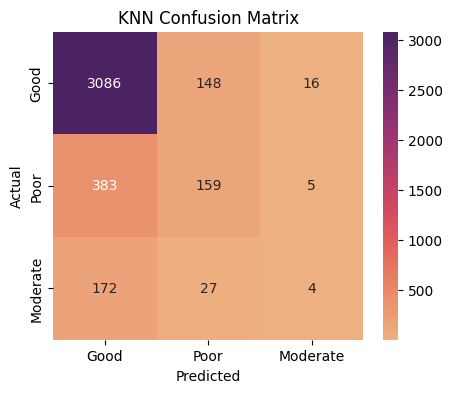

In [32]:
# Confusion Matrix
cm = np.zeros((len(np.unique(y_test)), len(np.unique(y_test))), dtype=int)
for t, p in zip(y_test, y_pred):
    cm[t, p] += 1

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare", xticklabels=uniques, yticklabels=uniques)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

### Plots

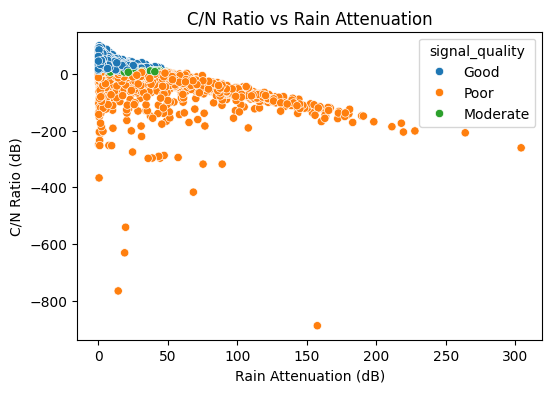

In [33]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['rain_attenuation_db'], y=df['cn_ratio_db'], hue=df['signal_quality'])
plt.xlabel("Rain Attenuation (dB)")
plt.ylabel("C/N Ratio (dB)")
plt.title("C/N Ratio vs Rain Attenuation")
plt.show()

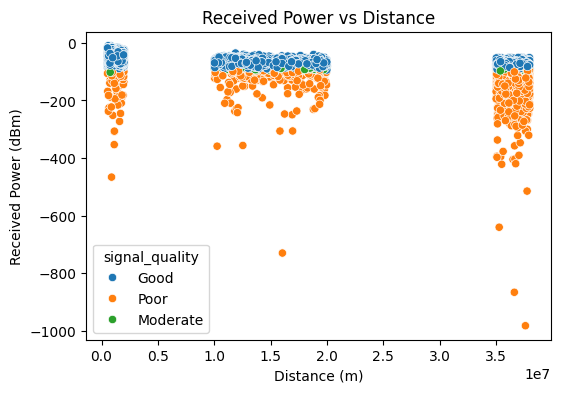

In [34]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['distance_m'], y=df['received_power_dbm'], hue=df['signal_quality'])
plt.xlabel("Distance (m)")
plt.ylabel("Received Power (dBm)")
plt.title("Received Power vs Distance")
plt.show()

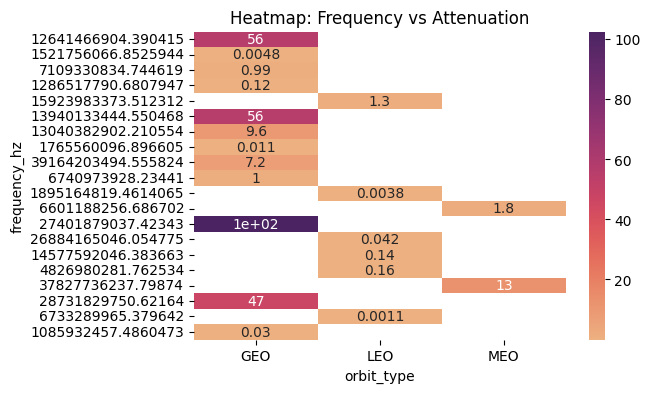

In [35]:
plt.figure(figsize=(6,4))
heatmap_data = df.pivot_table(values="rain_attenuation_db",
                              index="frequency_hz",
                              columns="orbit_type",
                              aggfunc="mean")
sampled_heatmap_data = heatmap_data.sample(n=20, random_state=42) # Sample 20 frequencies

sns.heatmap(sampled_heatmap_data, cmap="flare", annot=True)
plt.title("Heatmap: Frequency vs Attenuation")
plt.show()